**UAS Big Data & Predictive Analytics Lanjut**
Kelompok :


*   Faqih Rizky Al Faiz  (22.11.4774)
*   Qurata ayun          (22.11.4785)
*   syahid pratama putra wibowo (22.11.4803)
*   riki setiawan (22.11.4807)





In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import count, when, isnull
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Imputer
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from pyspark.ml.classification import LinearSVC, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
!pip install pyspark

# **Proses EDA**

In [4]:
spark = SparkSession.builder.appName('Hotel Reservations').getOrCreate()
df = spark.read.csv('/content/drive/MyDrive/Big data lanjut/Hotel Reservations.csv', header = True, inferSchema = True)

In [5]:
df.show()

+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+------------------+----------------------+--------------+
|Booking_ID|no_of_adults|no_of_children|no_of_weekend_nights|no_of_week_nights|type_of_meal_plan|required_car_parking_space|room_type_reserved|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|repeated_guest|no_of_previous_cancellations|no_of_previous_bookings_not_canceled|avg_price_per_room|no_of_special_requests|booking_status|
+----------+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+------------+-------------+------------+-------------------+--------------+----------------------------+------------------------------------+--

In [6]:
df.printSchema()

root
 |-- Booking_ID: string (nullable = true)
 |-- no_of_adults: integer (nullable = true)
 |-- no_of_children: integer (nullable = true)
 |-- no_of_weekend_nights: integer (nullable = true)
 |-- no_of_week_nights: integer (nullable = true)
 |-- type_of_meal_plan: string (nullable = true)
 |-- required_car_parking_space: integer (nullable = true)
 |-- room_type_reserved: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- repeated_guest: integer (nullable = true)
 |-- no_of_previous_cancellations: integer (nullable = true)
 |-- no_of_previous_bookings_not_canceled: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: integer (nullable = true)
 |-- booking_status: string (nullable = true)



In [7]:
# Memeriksa tipe data
print("Data Types:")
print(df.dtypes)

Data Types:
[('Booking_ID', 'string'), ('no_of_adults', 'int'), ('no_of_children', 'int'), ('no_of_weekend_nights', 'int'), ('no_of_week_nights', 'int'), ('type_of_meal_plan', 'string'), ('required_car_parking_space', 'int'), ('room_type_reserved', 'string'), ('lead_time', 'int'), ('arrival_year', 'int'), ('arrival_month', 'int'), ('arrival_date', 'int'), ('market_segment_type', 'string'), ('repeated_guest', 'int'), ('no_of_previous_cancellations', 'int'), ('no_of_previous_bookings_not_canceled', 'int'), ('avg_price_per_room', 'double'), ('no_of_special_requests', 'int'), ('booking_status', 'string')]


In [8]:
from pyspark.sql.functions import concat_ws, to_date

# Hapus kolom 'Booking_ID'
df = df.drop("Booking_ID")

# Gabungkan kolom 'arrival_year', 'arrival_month', dan 'arrival_date' menjadi satu kolom
df = df.withColumn("arrival_date_full", to_date(concat_ws("-", df.arrival_year, df.arrival_month, df.arrival_date)))

# Hapus kolom 'arrival_year', 'arrival_month', dan 'arrival_date' setelah digabungkan
df = df.drop("arrival_year", "arrival_month", "arrival_date")

# Tampilkan skema setelah transformasi (opsional)
df.printSchema()

# Tampilkan data untuk memastikan hasil (opsional)
df.show(5)


root
 |-- no_of_adults: integer (nullable = true)
 |-- no_of_children: integer (nullable = true)
 |-- no_of_weekend_nights: integer (nullable = true)
 |-- no_of_week_nights: integer (nullable = true)
 |-- type_of_meal_plan: string (nullable = true)
 |-- required_car_parking_space: integer (nullable = true)
 |-- room_type_reserved: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- repeated_guest: integer (nullable = true)
 |-- no_of_previous_cancellations: integer (nullable = true)
 |-- no_of_previous_bookings_not_canceled: integer (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: integer (nullable = true)
 |-- booking_status: string (nullable = true)
 |-- arrival_date_full: date (nullable = true)

+------------+--------------+--------------------+-----------------+-----------------+--------------------------+------------------+---------+-------------------+-----------

In [12]:
# Hapus kolom 'arrival_date_full' (tanggal_kedatangan)
df = df.drop("tanggal_kedatangan")

# Mengganti nama kolom yang tersisa
for old_name, new_name in {
    'no_of_adults': 'jumlah_dewasa',
    'no_of_children': 'jumlah_anak',
    'no_of_weekend_nights': 'jumlah_malam_akhir_pekan',
    'no_of_week_nights': 'jumlah_malam_hari_kerja',
    'type_of_meal_plan': 'jenis_paket_makanan',
    'required_car_parking_space': 'butuh_tempat_parkir',
    'room_type_reserved': 'jenis_kamar_dipesan',
    'lead_time': 'waktu_pemesanan',
    'market_segment_type': 'jenis_segmen_pasar',
    'repeated_guest': 'tamu_berulang',
    'no_of_previous_cancellations': 'jumlah_pembatalan_sebelumnya',
    'no_of_previous_bookings_not_canceled': 'jumlah_pesanan_tidak_dibatalkan_sebelumnya',
    'avg_price_per_room': 'rata_rata_harga_per_kamar',
    'no_of_special_requests': 'jumlah_permintaan_khusus',
    'booking_status': 'status_pemesanan'
}.items():
    df = df.withColumnRenamed(old_name, new_name)

# Tampilkan data untuk verifikasi
df.show()


+-------------+-----------+------------------------+-----------------------+-------------------+-------------------+-------------------+---------------+------------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+----------------+
|jumlah_dewasa|jumlah_anak|jumlah_malam_akhir_pekan|jumlah_malam_hari_kerja|jenis_paket_makanan|butuh_tempat_parkir|jenis_kamar_dipesan|waktu_pemesanan|jenis_segmen_pasar|tamu_berulang|jumlah_pembatalan_sebelumnya|jumlah_pesanan_tidak_dibatalkan_sebelumnya|rata_rata_harga_per_kamar|jumlah_permintaan_khusus|status_pemesanan|
+-------------+-----------+------------------------+-----------------------+-------------------+-------------------+-------------------+---------------+------------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+----------------+
|            2|       

In [13]:
# Menghitung jumlah nilai null di setiap kolom
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+-------------+-----------+------------------------+-----------------------+-------------------+-------------------+-------------------+---------------+------------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+----------------+
|jumlah_dewasa|jumlah_anak|jumlah_malam_akhir_pekan|jumlah_malam_hari_kerja|jenis_paket_makanan|butuh_tempat_parkir|jenis_kamar_dipesan|waktu_pemesanan|jenis_segmen_pasar|tamu_berulang|jumlah_pembatalan_sebelumnya|jumlah_pesanan_tidak_dibatalkan_sebelumnya|rata_rata_harga_per_kamar|jumlah_permintaan_khusus|status_pemesanan|
+-------------+-----------+------------------------+-----------------------+-------------------+-------------------+-------------------+---------------+------------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+----------------+
|            0|       

# **Proses Preprocessing**

In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StringType

# Mendapatkan daftar kolom dengan tipe String
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

# Loop melalui setiap kolom string dan ubah ke indeks
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    df = indexer.fit(df).transform(df)

    # Hapus kolom lama dan ganti dengan kolom baru
    df = df.drop(col).withColumnRenamed(col + "_index", col)

# Menampilkan skema DataFrame (opsional)
df.printSchema()


root
 |-- jumlah_dewasa: integer (nullable = true)
 |-- jumlah_anak: integer (nullable = true)
 |-- jumlah_malam_akhir_pekan: integer (nullable = true)
 |-- jumlah_malam_hari_kerja: integer (nullable = true)
 |-- butuh_tempat_parkir: integer (nullable = true)
 |-- waktu_pemesanan: integer (nullable = true)
 |-- tamu_berulang: integer (nullable = true)
 |-- jumlah_pembatalan_sebelumnya: integer (nullable = true)
 |-- jumlah_pesanan_tidak_dibatalkan_sebelumnya: integer (nullable = true)
 |-- rata_rata_harga_per_kamar: double (nullable = true)
 |-- jumlah_permintaan_khusus: integer (nullable = true)
 |-- jenis_paket_makanan: double (nullable = false)
 |-- jenis_kamar_dipesan: double (nullable = false)
 |-- jenis_segmen_pasar: double (nullable = false)
 |-- status_pemesanan: double (nullable = false)



In [15]:
# mengecek apakah data sudah di konversi ke numerik semua atau belum
df.show()

+-------------+-----------+------------------------+-----------------------+-------------------+---------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+-------------------+-------------------+------------------+----------------+
|jumlah_dewasa|jumlah_anak|jumlah_malam_akhir_pekan|jumlah_malam_hari_kerja|butuh_tempat_parkir|waktu_pemesanan|tamu_berulang|jumlah_pembatalan_sebelumnya|jumlah_pesanan_tidak_dibatalkan_sebelumnya|rata_rata_harga_per_kamar|jumlah_permintaan_khusus|jenis_paket_makanan|jenis_kamar_dipesan|jenis_segmen_pasar|status_pemesanan|
+-------------+-----------+------------------------+-----------------------+-------------------+---------------+-------------+----------------------------+------------------------------------------+-------------------------+------------------------+-------------------+-------------------+------------------+----------------+
|            2|       

# **EDA Lanjutan**

In [16]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import corr
from pyspark.sql.types import NumericType
# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Inisialisasi matriks korelasi
num_cols = len(numeric_cols)
corr_matrix = np.zeros((num_cols, num_cols))

# Menghitung korelasi dan mengisi matriks
for i in range(num_cols):
    for j in range(i, num_cols):
        correlation = df.select(corr(numeric_cols[i], numeric_cols[j])).collect()[0][0]
        corr_matrix[i, j] = correlation
        corr_matrix[j, i] = correlation  # Matriks korelasi simetris

# Membuat DataFrame Pandas untuk visualisasi
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# Menampilkan hasil korelasi
print("Matriks Korelasi:")
print(corr_df.to_string())

Matriks Korelasi:
                                            jumlah_dewasa  jumlah_anak  jumlah_malam_akhir_pekan  jumlah_malam_hari_kerja  butuh_tempat_parkir  waktu_pemesanan  tamu_berulang  jumlah_pembatalan_sebelumnya  jumlah_pesanan_tidak_dibatalkan_sebelumnya  rata_rata_harga_per_kamar  jumlah_permintaan_khusus  jenis_paket_makanan  jenis_kamar_dipesan  jenis_segmen_pasar  status_pemesanan
jumlah_dewasa                                    1.000000    -0.019787                  0.103316                 0.105622             0.011429         0.097287      -0.192277                     -0.047426                                   -0.119166                   0.296886                  0.189401             0.027698             0.143541           -0.314103          0.086920
jumlah_anak                                     -0.019787     1.000000                  0.029478                 0.024398             0.034244        -0.047091      -0.036348                     -0.016390              

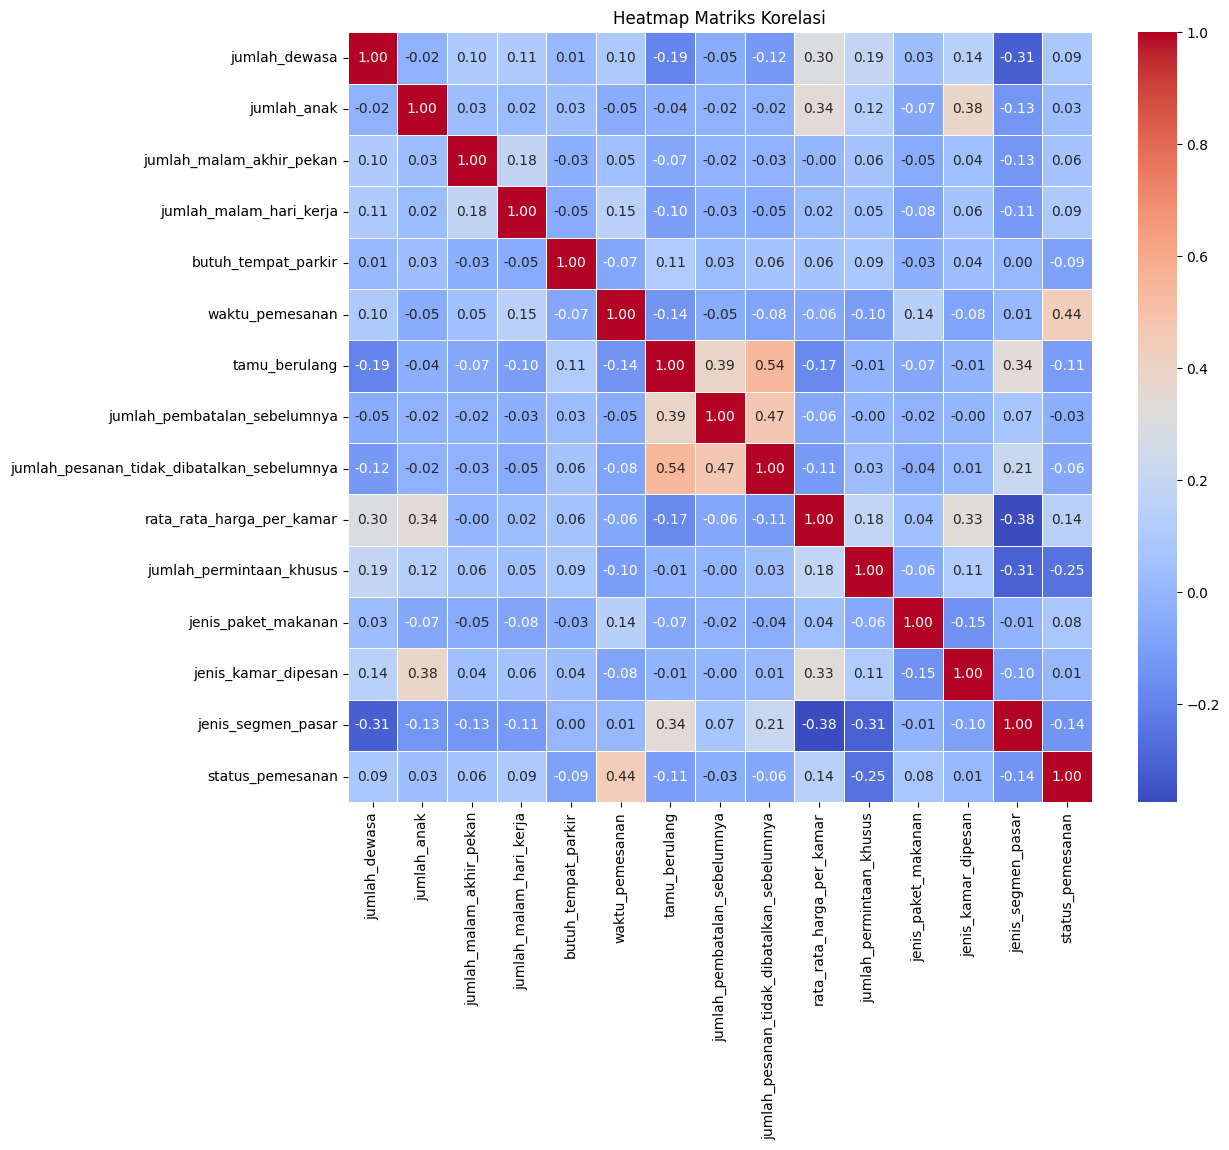

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap Matriks Korelasi")
plt.show()


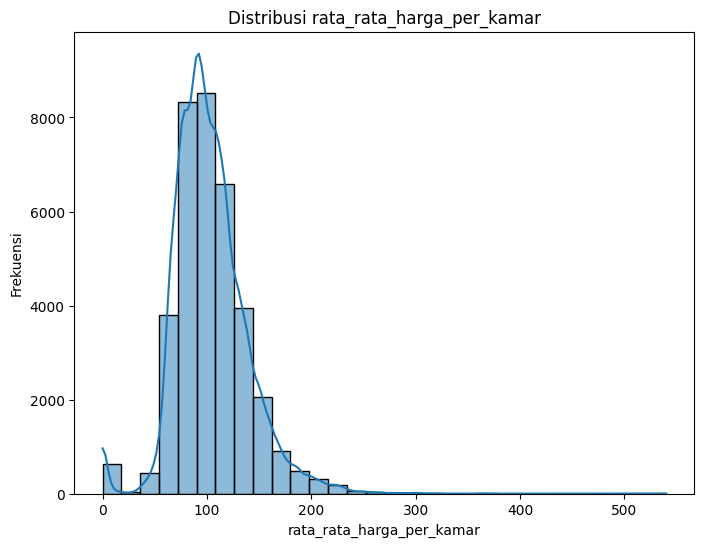

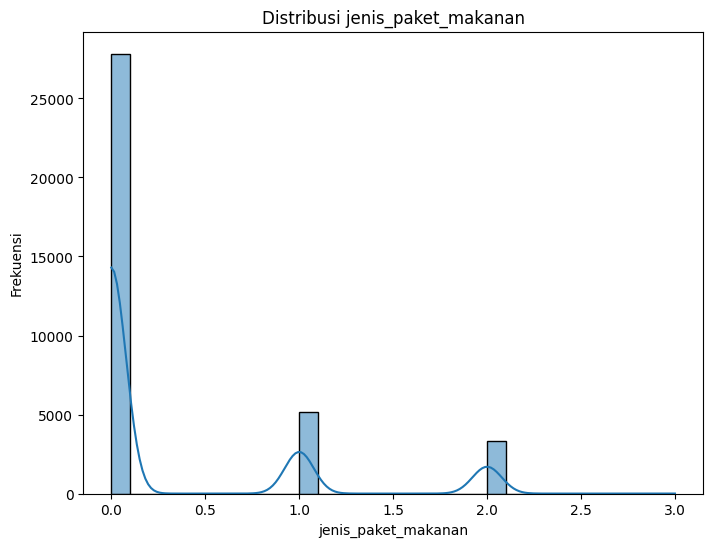

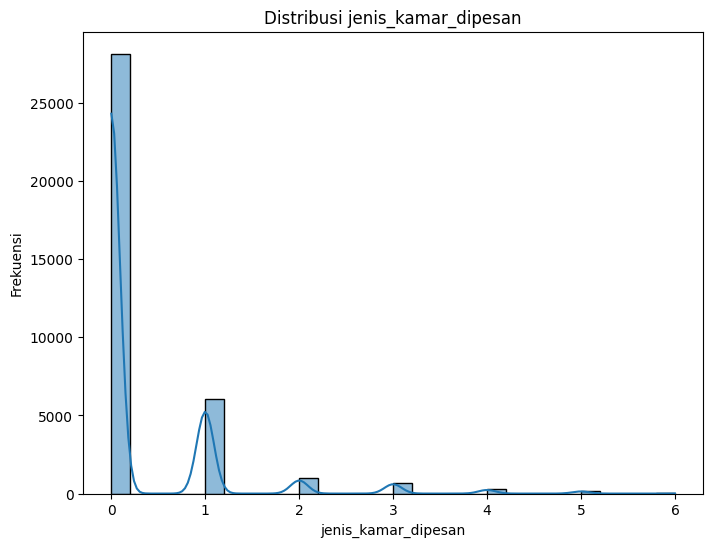

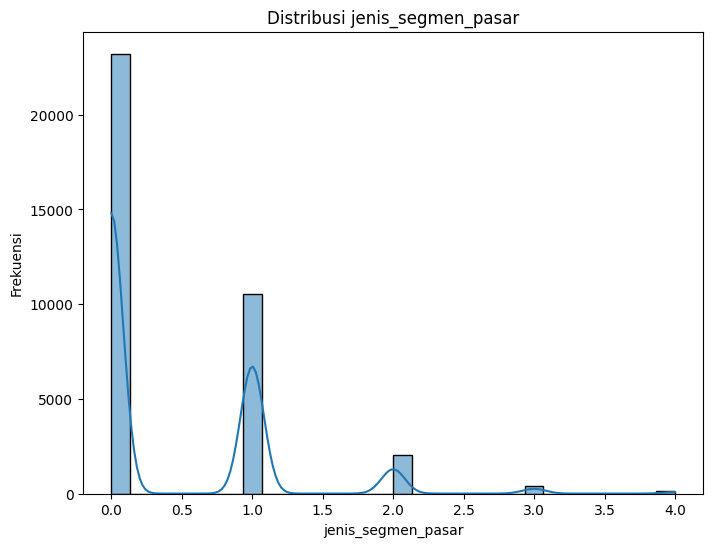

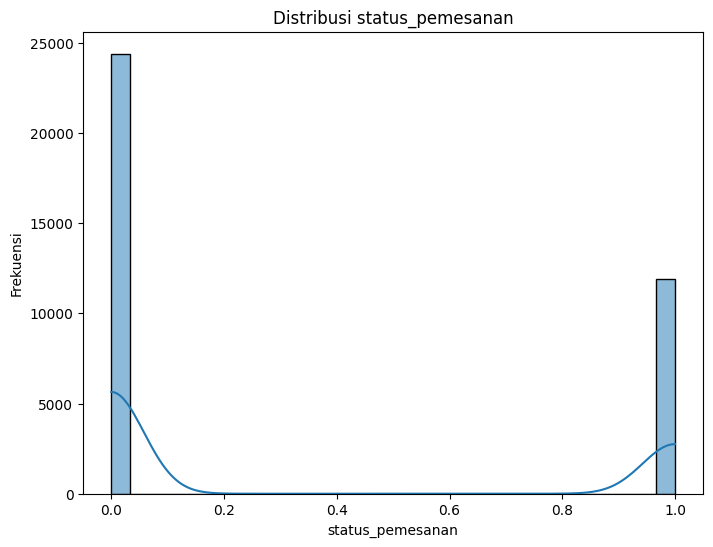

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop melalui semua kolom
for column in df.columns:
    # Mengambil data untuk kolom saat ini
    column_data = df.select(column).toPandas()

    # Jika kolom kategorikal, buat bar chart
    if column_data[column].dtype == 'object' or column_data[column].dtype.name == 'category':
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=column_data)
        plt.title(f'Distribusi {column}')
        plt.xlabel(column)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45, ha='right')  # Rotasi label sumbu x jika diperlukan
        plt.show()
    # Jika kolom numerik, buat histogram
    elif column_data[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 6))
        sns.histplot(column_data[column], kde=True, bins=30)
        plt.title(f'Distribusi {column}')
        plt.xlabel(column)
        plt.ylabel('Frekuensi')
        plt.show()


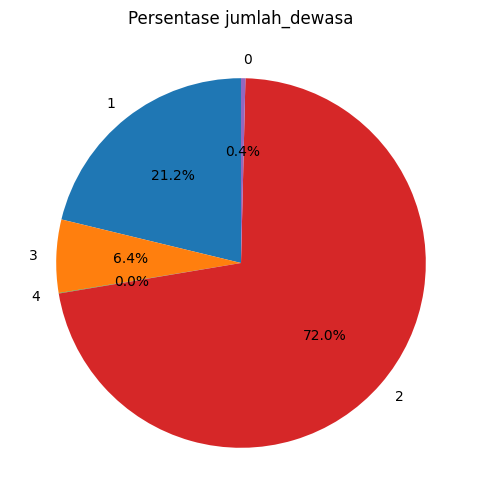

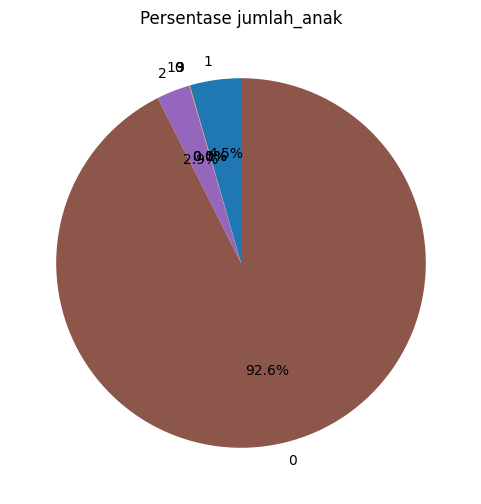

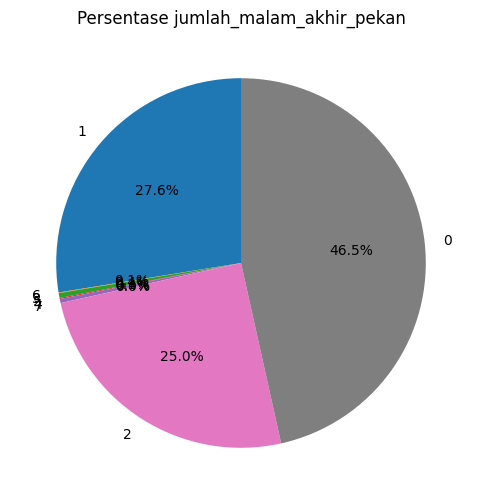

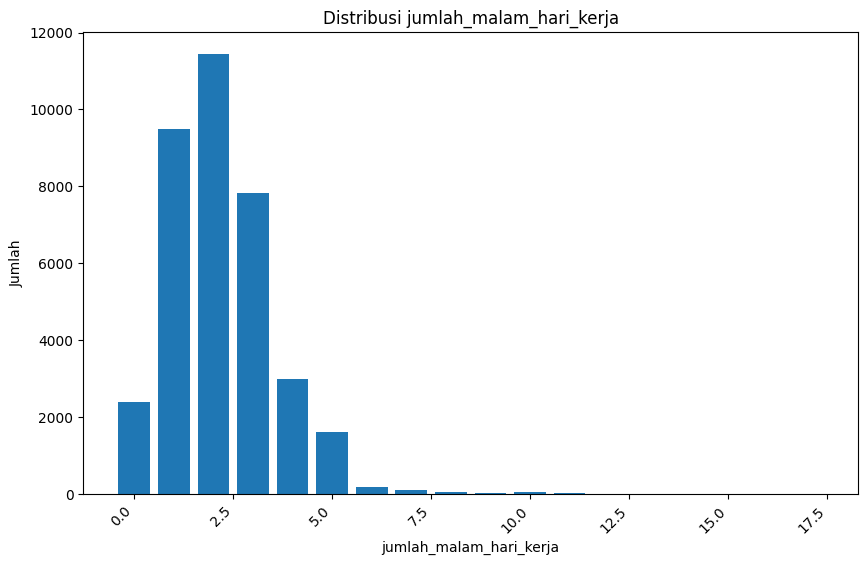

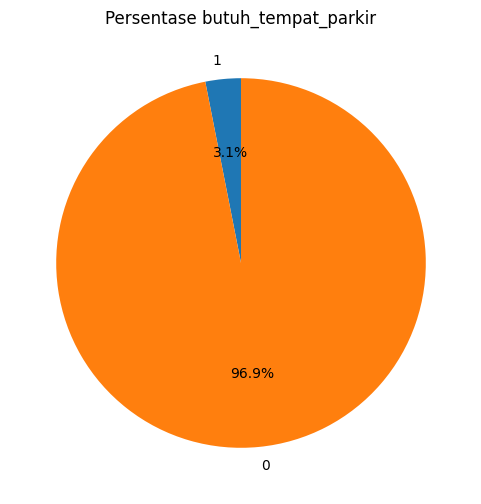

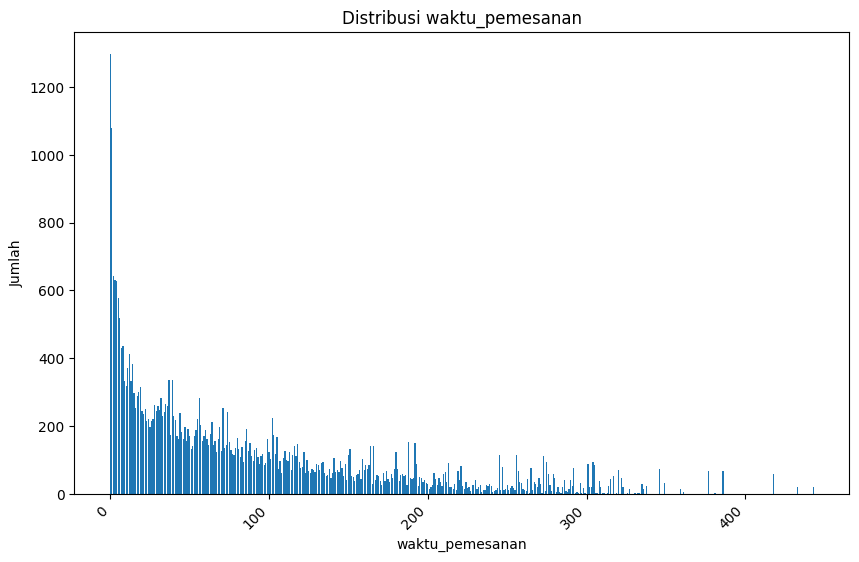

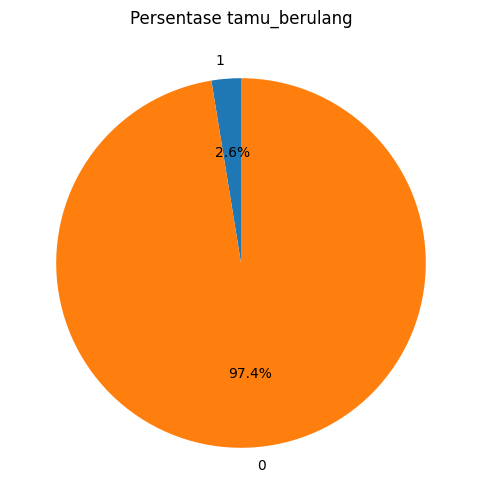

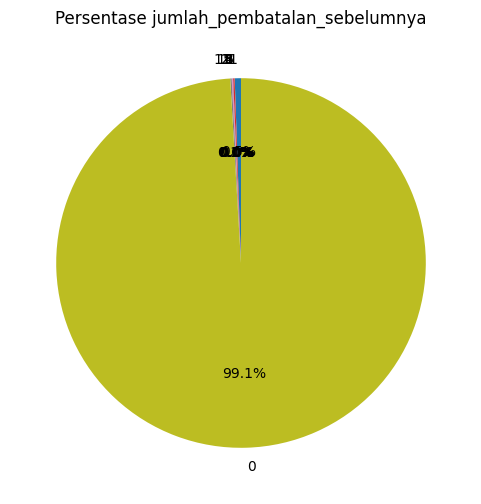

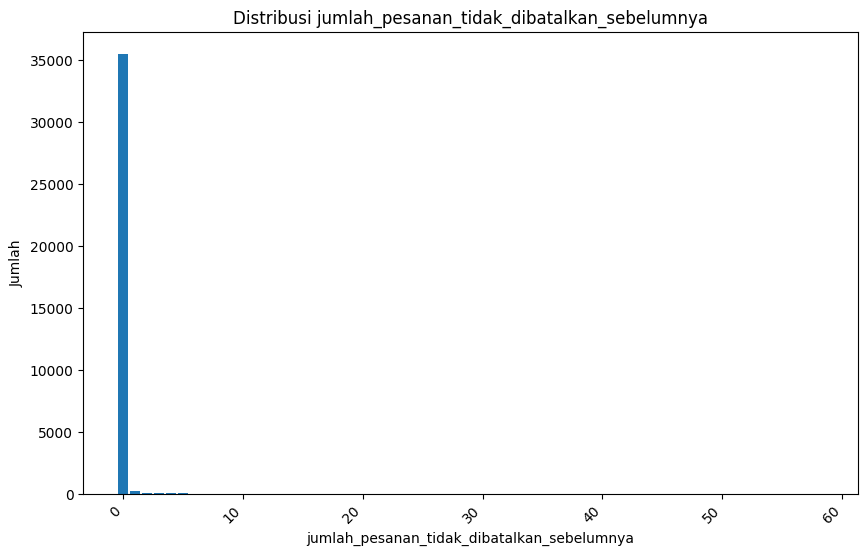

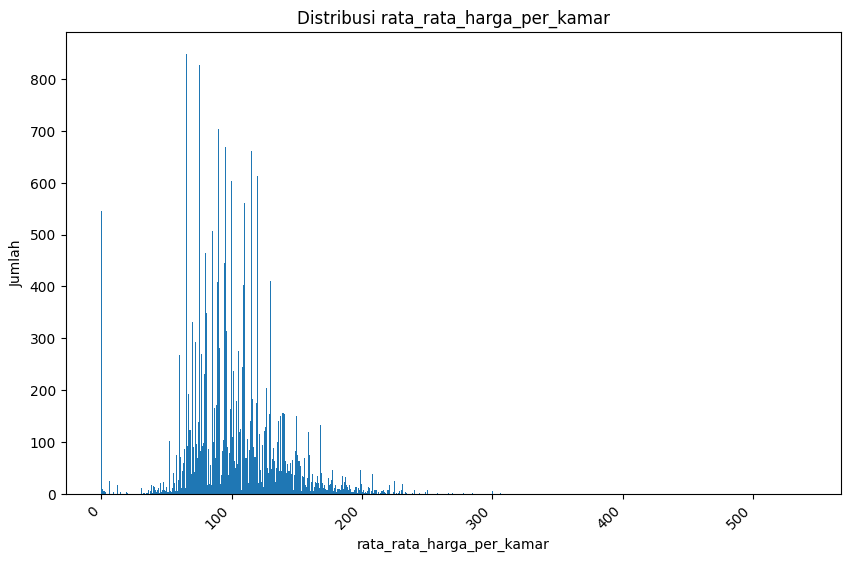

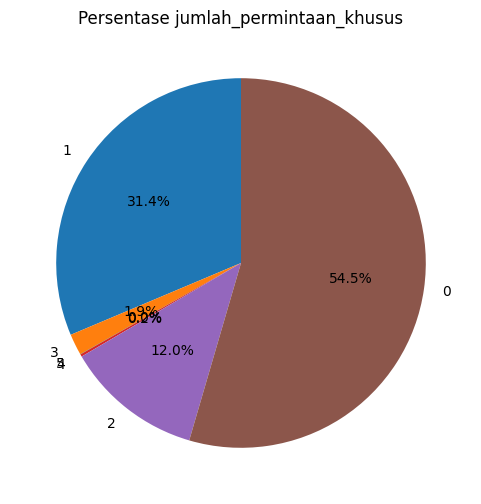

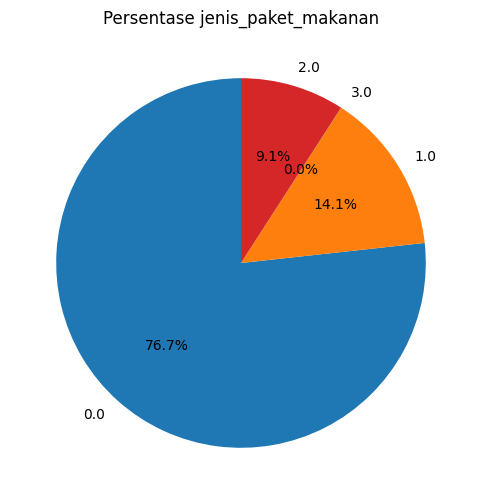

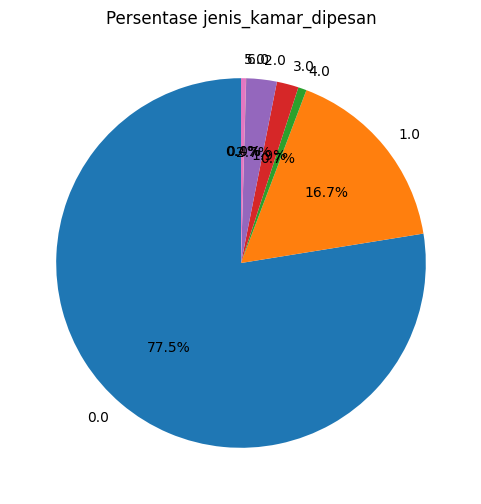

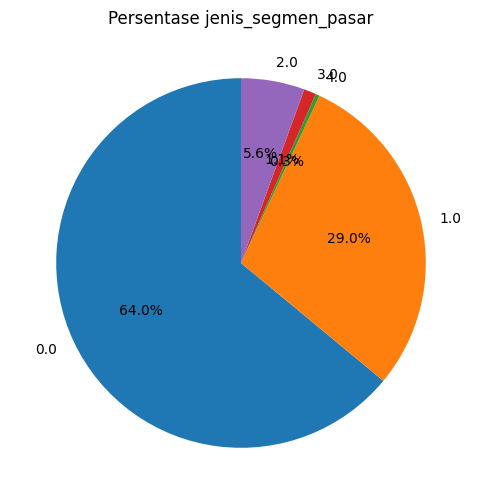

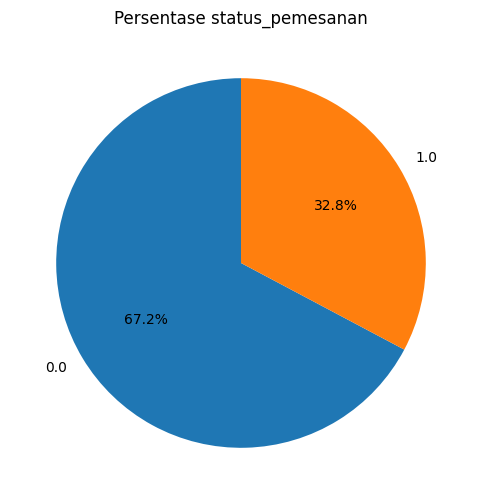

In [19]:
import matplotlib.pyplot as plt

# Loop melalui semua kolom dalam DataFrame
for column in df.columns:
    # Menghitung frekuensi nilai dalam kolom
    value_counts = df.groupBy(column).count().toPandas()

    # Filter untuk kolom dengan jumlah kategori terbatas
    if len(value_counts) <= 10:  # Mengatur batasan untuk kategori terbatas
        # Membuat pie chart
        plt.figure(figsize=(6, 6))
        plt.pie(value_counts["count"], labels=value_counts[column], autopct='%1.1f%%', startangle=90)
        plt.title(f'Persentase {column}')
        plt.show()
    else:
        # Jika terlalu banyak kategori, gunakan bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(value_counts[column], value_counts["count"])
        plt.title(f'Distribusi {column}')
        plt.xlabel(column)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45, ha='right')
        plt.show()


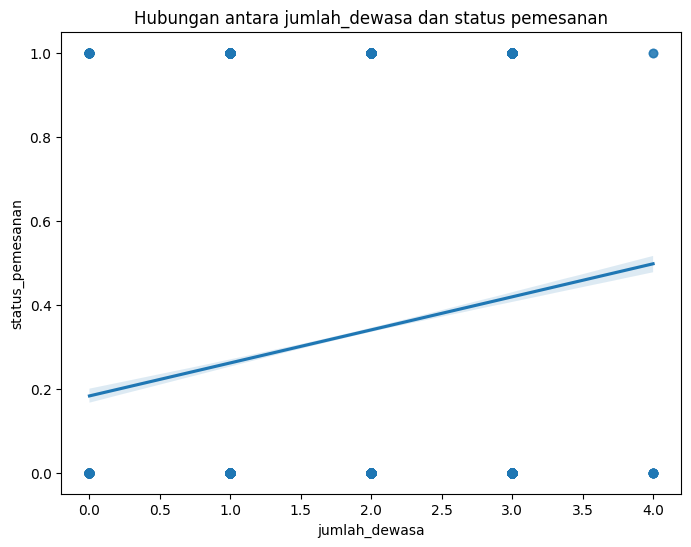

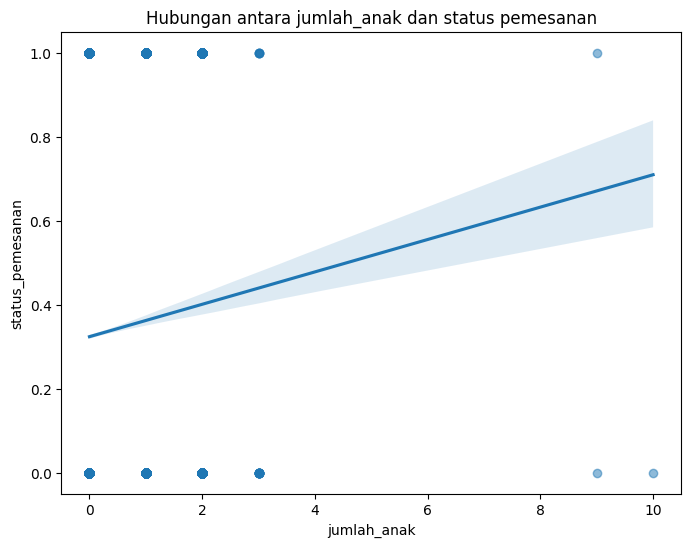

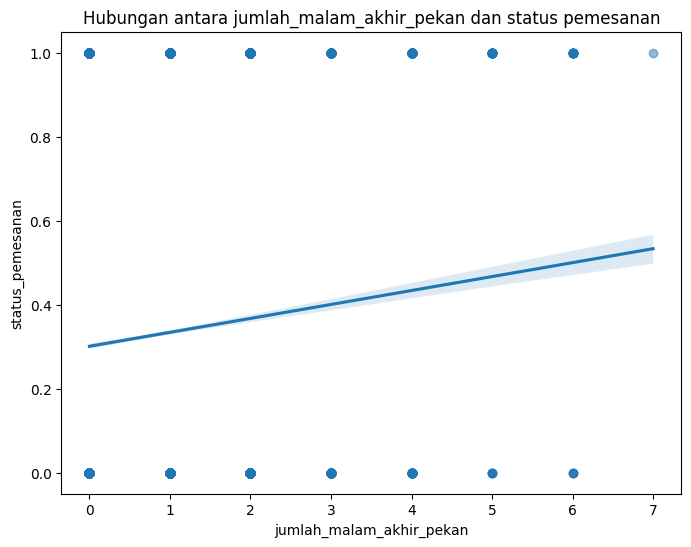

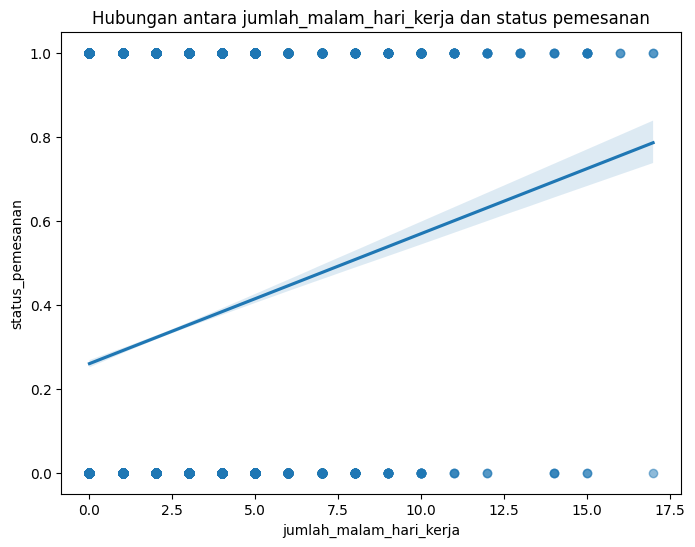

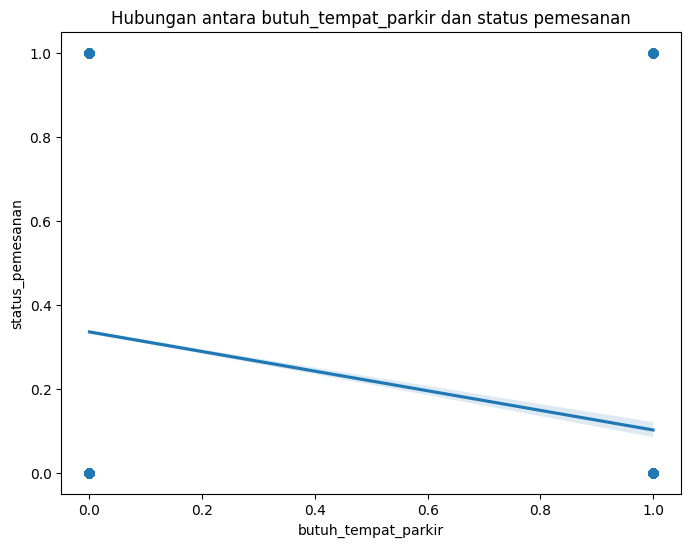

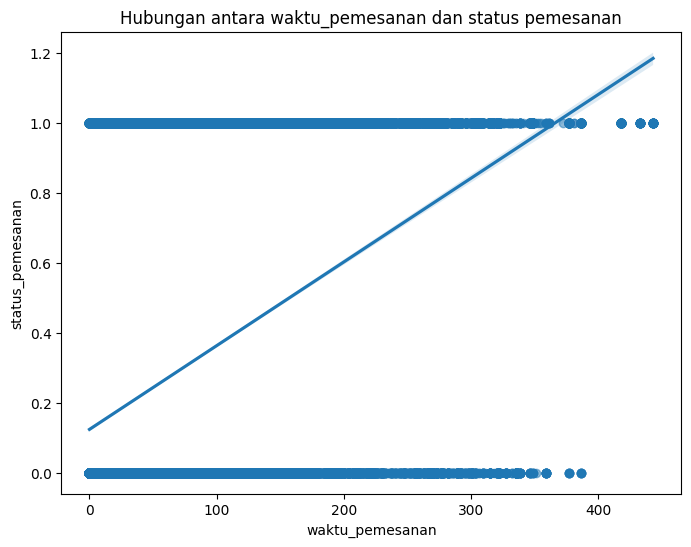

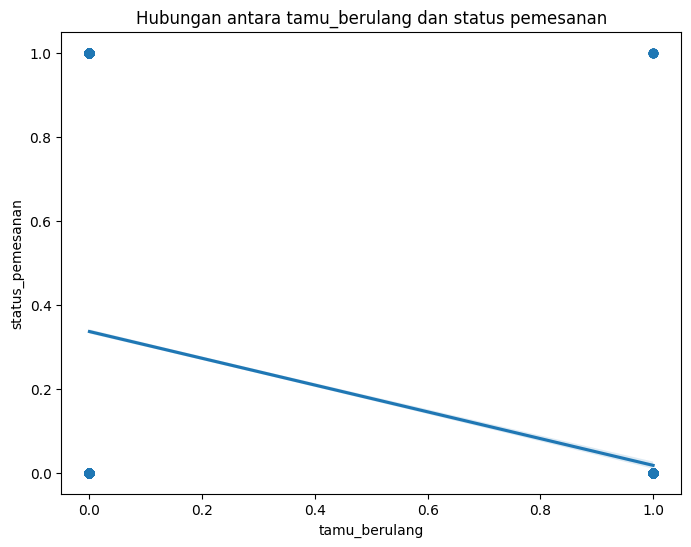

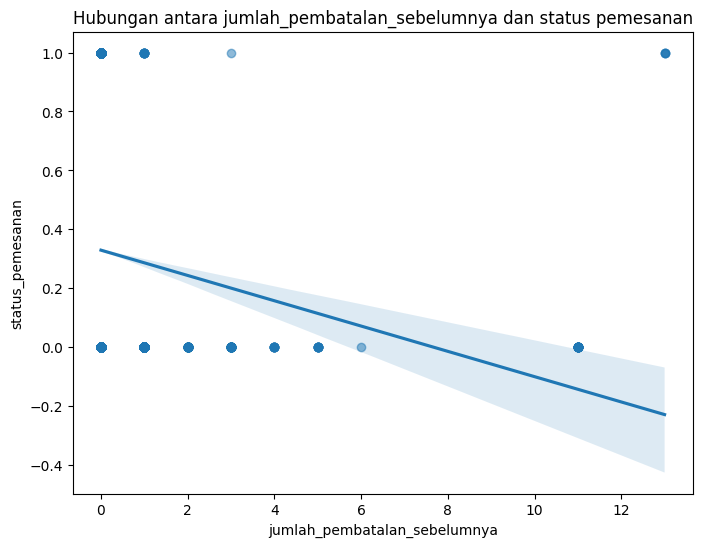

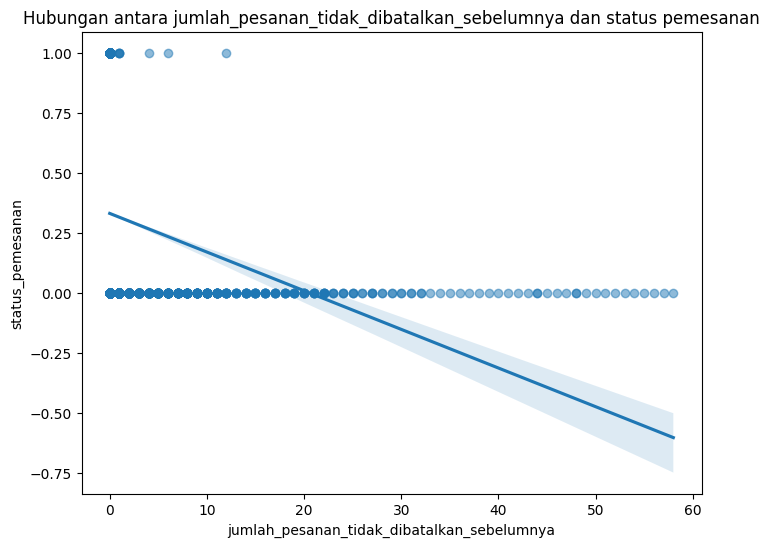

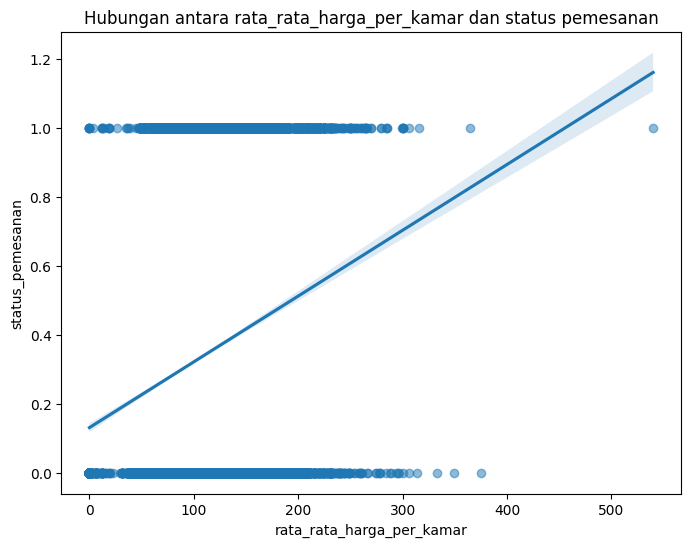

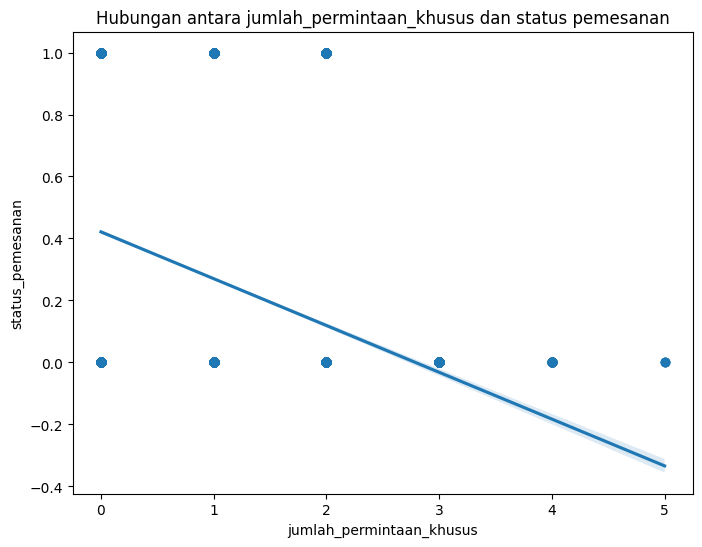

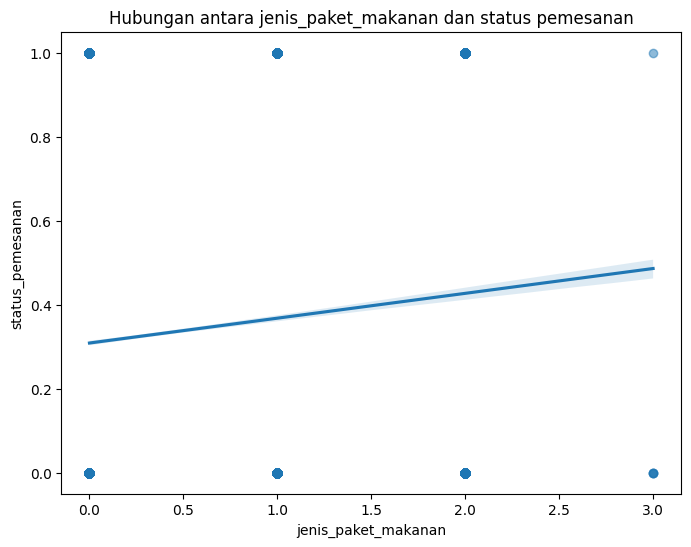

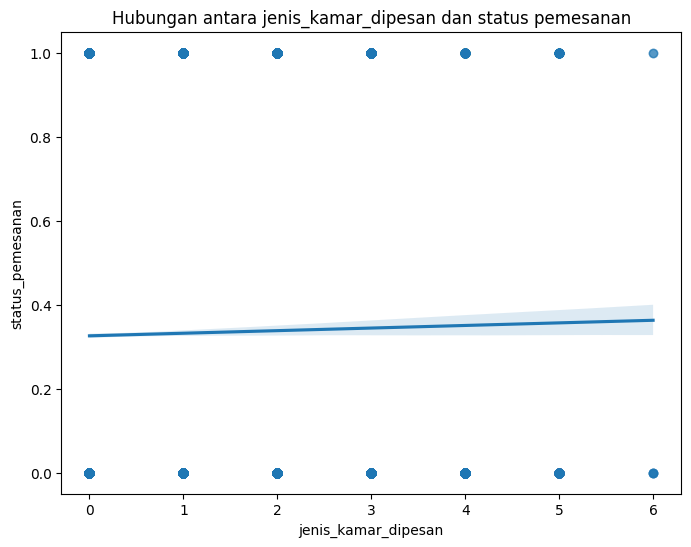

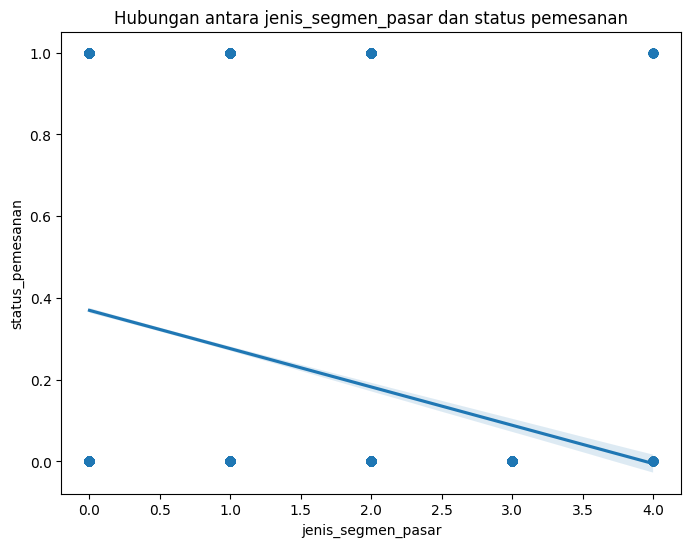

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Loop melalui kolom numerik (kecuali 'Depression')
for column in numeric_cols:
    if column != 'status_pemesanan':
        # Mengambil data untuk kolom saat ini dan 'Depression'
        data = df.select(column, 'status_pemesanan').toPandas()

        # Membuat scatter plot dengan garis regresi menggunakan seaborn dan matplotlib
        plt.figure(figsize=(8, 6))
        sns.regplot(x=column, y='status_pemesanan', data=data, scatter_kws={'alpha':0.5})
        plt.title(f'Hubungan antara {column} dan status pemesanan')
        plt.xlabel(column)
        plt.ylabel('status_pemesanan')
        plt.show()


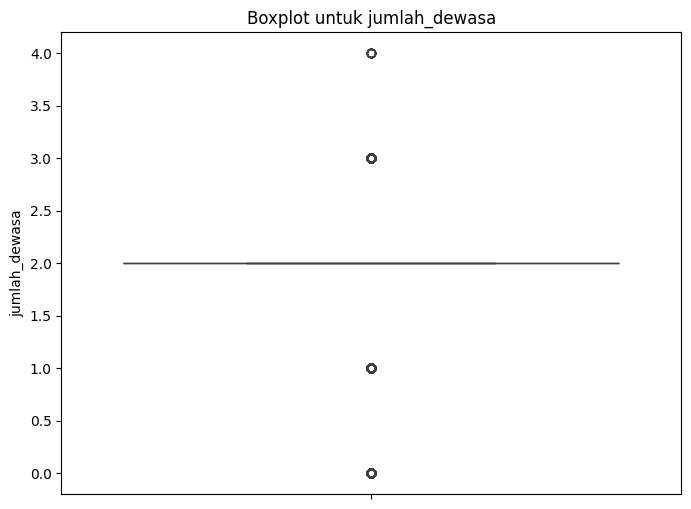

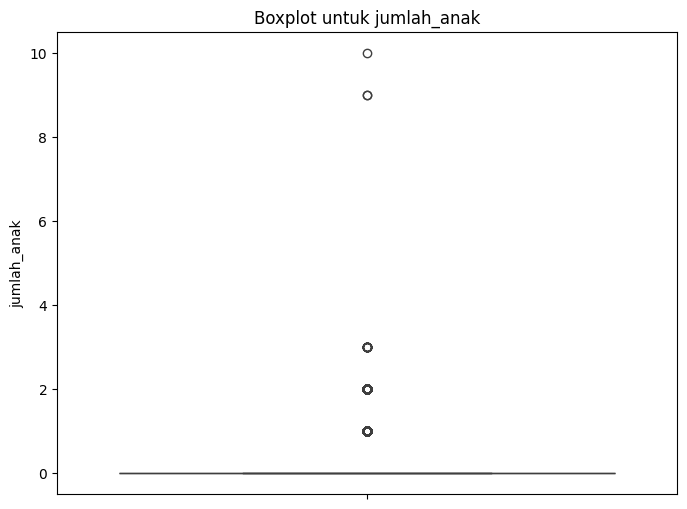

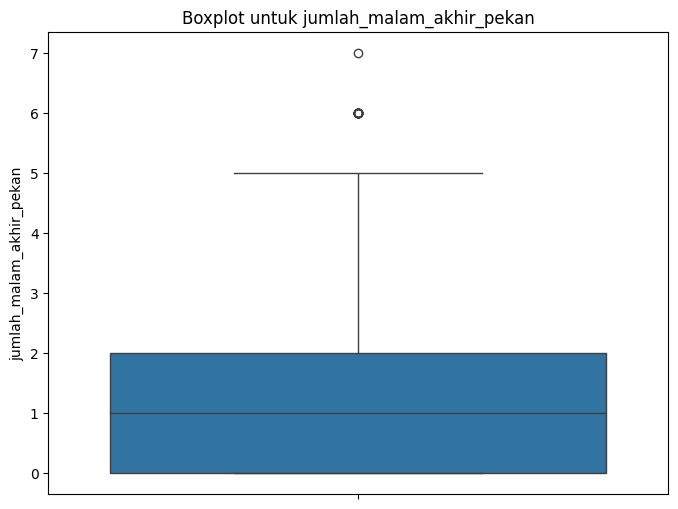

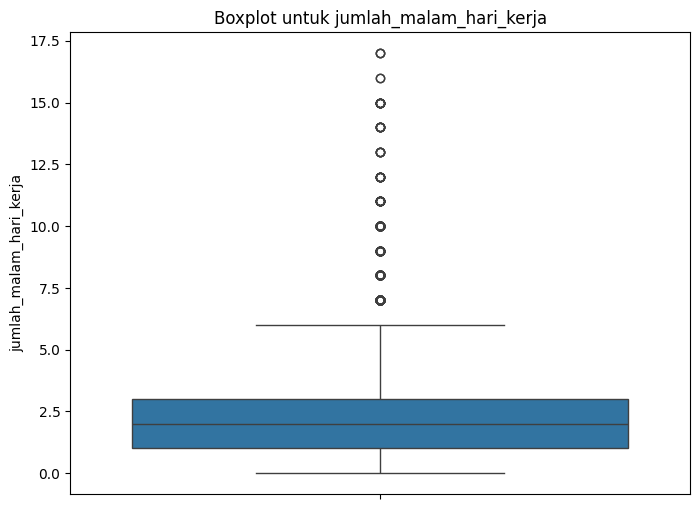

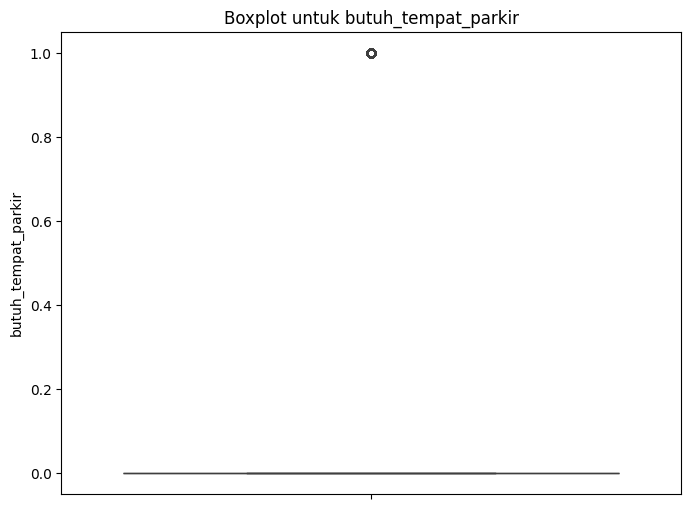

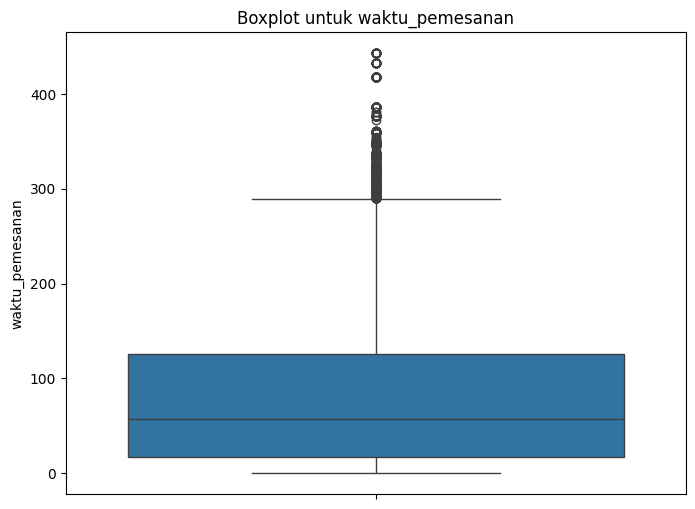

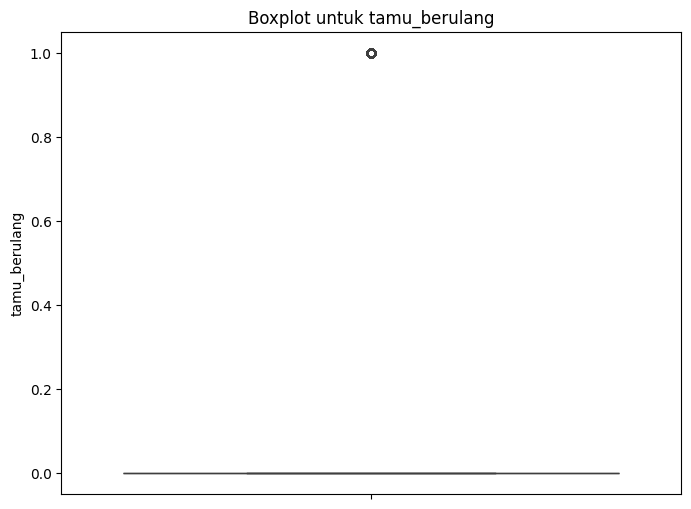

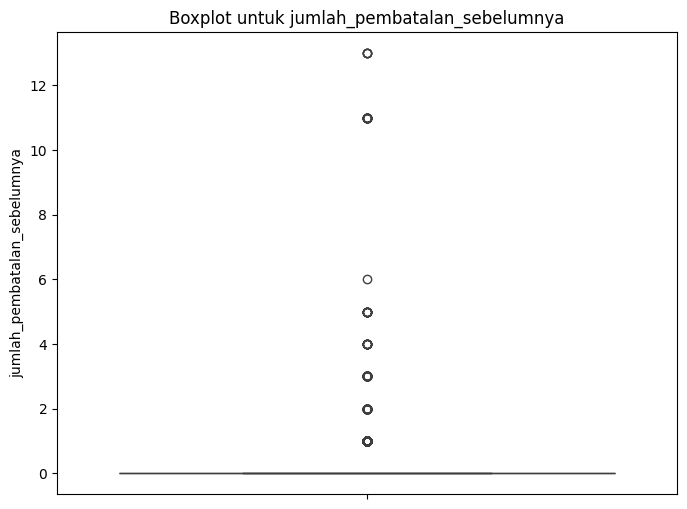

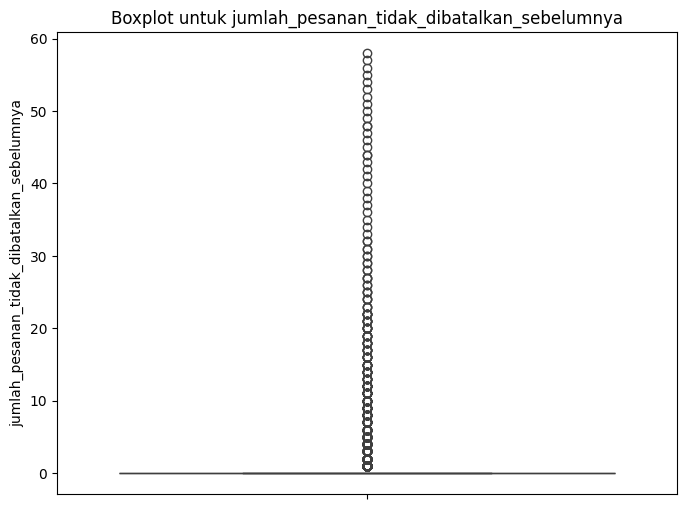

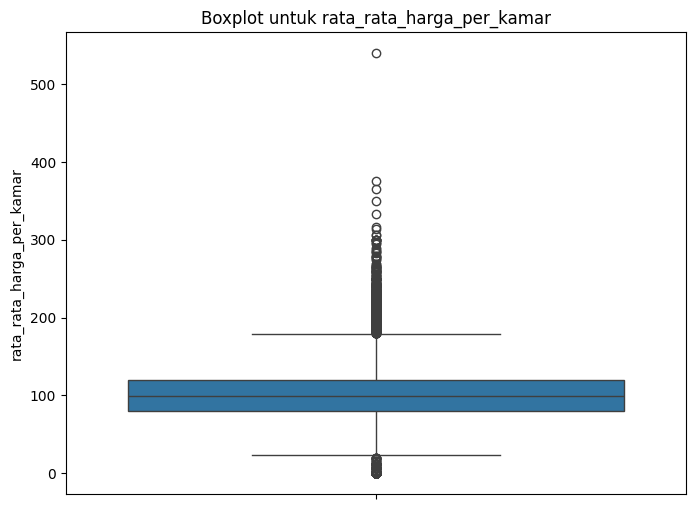

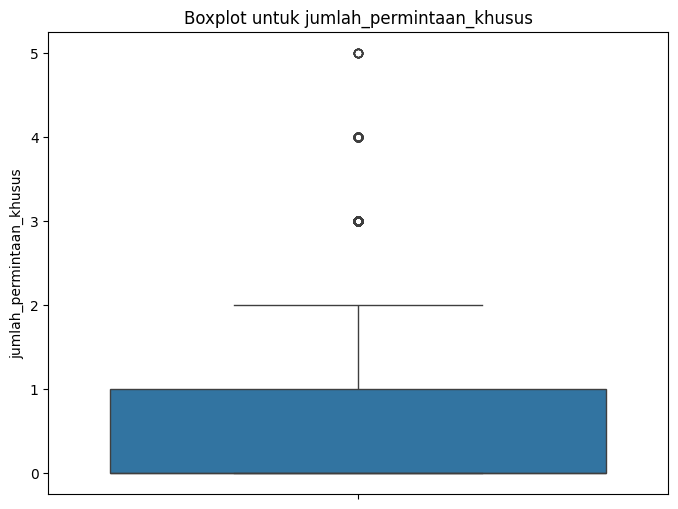

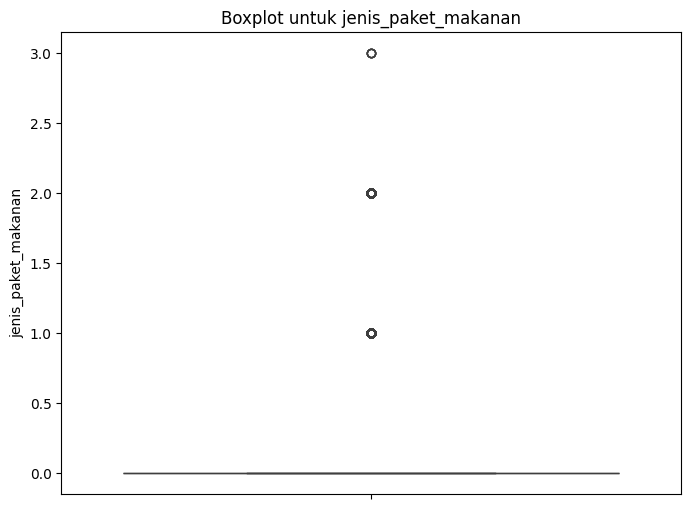

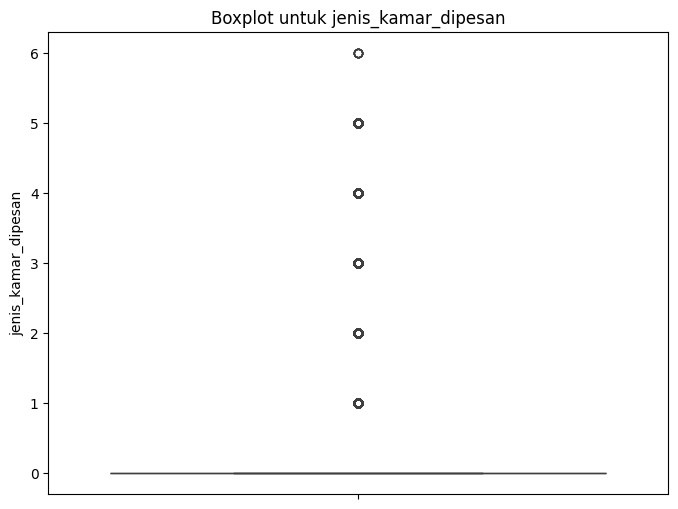

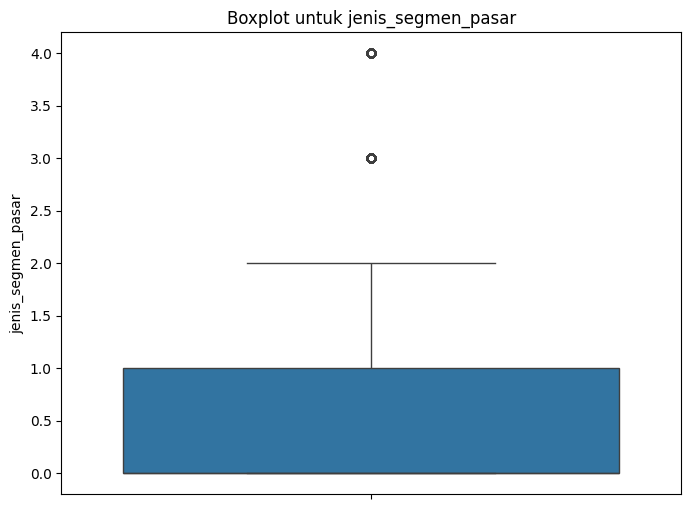

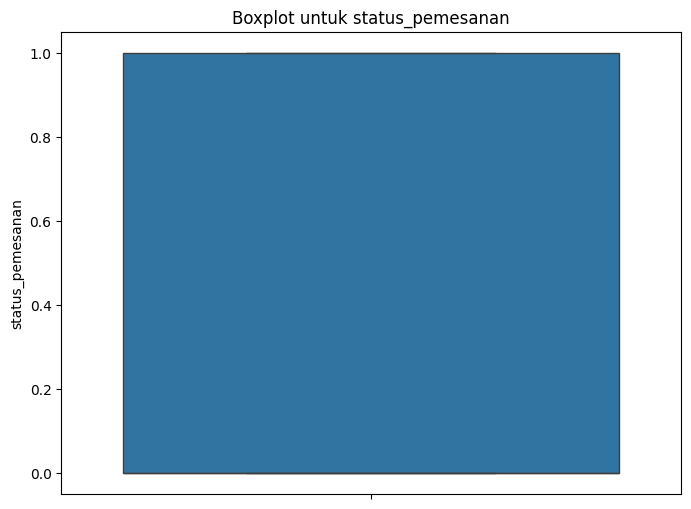

In [21]:
# Mendapatkan daftar kolom numerik
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Loop melalui setiap kolom numerik dan buat boxplot terpisah
for column in numeric_cols:
    # Mengambil data untuk kolom saat ini
    column_data = df.select(column).toPandas()

    # Membuat boxplot menggunakan seaborn dan matplotlib
    plt.figure(figsize=(8, 6))  # Mengatur ukuran figure
    sns.boxplot(y=column, data=column_data)  # Membuat boxplot untuk kolom saat ini
    plt.title(f'Boxplot untuk {column}')  # Memberi judul plot dengan nama kolom
    plt.show()  # Menampilkan plot

# **Proses Preprocessing Lanjutan**

In [22]:
# Mengonversi DataFrame Spark menjadi Pandas
pandas_df = df.toPandas()

#  kolom target adalah 'status_pemesanan'
X = pandas_df.drop("status_pemesanan", axis=1)  # Menghapus kolom target dari fitur
y = pandas_df["status_pemesanan"]  # Kolom target

# Menyelesaikan ketidakseimbangan dengan SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mengonversi kembali hasil resampling menjadi DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['status_pemesanan'] = y_resampled  # Menambahkan kolom target yang telah di-resample

# Membuat Spark session
spark = SparkSession.builder.appName('Data_Balancing').getOrCreate()

# Mengonversi DataFrame Pandas yang sudah seimbang kembali ke Spark DataFrame
balanced_df = spark.createDataFrame(resampled_df)

# Menampilkan skema DataFrame yang telah seimbang
balanced_df.printSchema()

root
 |-- jumlah_dewasa: long (nullable = true)
 |-- jumlah_anak: long (nullable = true)
 |-- jumlah_malam_akhir_pekan: long (nullable = true)
 |-- jumlah_malam_hari_kerja: long (nullable = true)
 |-- butuh_tempat_parkir: long (nullable = true)
 |-- waktu_pemesanan: long (nullable = true)
 |-- tamu_berulang: long (nullable = true)
 |-- jumlah_pembatalan_sebelumnya: long (nullable = true)
 |-- jumlah_pesanan_tidak_dibatalkan_sebelumnya: long (nullable = true)
 |-- rata_rata_harga_per_kamar: double (nullable = true)
 |-- jumlah_permintaan_khusus: long (nullable = true)
 |-- jenis_paket_makanan: double (nullable = true)
 |-- jenis_kamar_dipesan: double (nullable = true)
 |-- jenis_segmen_pasar: double (nullable = true)
 |-- status_pemesanan: double (nullable = true)



In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Membuat list kolom fitur dengan mengecualikan kolom target 'status_pemesanan'
feature_columns = [col for col in balanced_df.columns if col != 'status_pemesanan']

# Inisialisasi VectorAssembler untuk membuat fitur vektor
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Menerapkan transformasi pada DataFrame untuk membuat fitur vektor
balanced_df = assembler.transform(balanced_df)

# Menampilkan skema DataFrame setelah penambahan kolom 'features'
balanced_df.printSchema()


root
 |-- jumlah_dewasa: long (nullable = true)
 |-- jumlah_anak: long (nullable = true)
 |-- jumlah_malam_akhir_pekan: long (nullable = true)
 |-- jumlah_malam_hari_kerja: long (nullable = true)
 |-- butuh_tempat_parkir: long (nullable = true)
 |-- waktu_pemesanan: long (nullable = true)
 |-- tamu_berulang: long (nullable = true)
 |-- jumlah_pembatalan_sebelumnya: long (nullable = true)
 |-- jumlah_pesanan_tidak_dibatalkan_sebelumnya: long (nullable = true)
 |-- rata_rata_harga_per_kamar: double (nullable = true)
 |-- jumlah_permintaan_khusus: long (nullable = true)
 |-- jenis_paket_makanan: double (nullable = true)
 |-- jenis_kamar_dipesan: double (nullable = true)
 |-- jenis_segmen_pasar: double (nullable = true)
 |-- status_pemesanan: double (nullable = true)
 |-- features: vector (nullable = true)



In [24]:
# Melakukan split data menjadi data latih (train) dan data uji (test) dengan perbandingan 80:20
train, test = balanced_df.randomSplit([0.8, 0.2], seed=42)

# Menampilkan jumlah baris pada data latih dan data uji
print(f"Jumlah data latih: {train.count()}")
print(f"Jumlah data uji: {test.count()}")


Jumlah data latih: 39155
Jumlah data uji: 9625


# **Pemodelan**

**1.Random Forest**

In [25]:
rf = RandomForestClassifier(labelCol="status_pemesanan", featuresCol="features", numTrees=100, maxDepth=10)

rf_model = rf.fit(train)

rf_predictions = rf_model.transform(test)

**2.Gradient Boost**

In [26]:
gbt = GBTClassifier(labelCol="status_pemesanan", featuresCol="features", maxIter=100)

gbt_model = gbt.fit(train)

gbt_predictions = gbt_model.transform(test)

**3. SVM**

In [27]:
svm = LinearSVC(labelCol="status_pemesanan", featuresCol="features")

svm_model = svm.fit(train)

svm_predictions = svm_model.transform(test)

**4. MLP**

In [28]:
# Pastikan layers sesuai dengan data
layers = [len(feature_columns), 16, 8, 2]  # Struktur jaringan: input -> hidden1 -> hidden2 -> output

# Definisikan model Multilayer Perceptron
mlp = MultilayerPerceptronClassifier(
    labelCol="status_pemesanan",
    featuresCol="features",
    layers=layers,
    blockSize=128,
    seed=42
)

# Melatih model
mlp_model = mlp.fit(train)

# Melakukan prediksi pada data uji
mlp_predictions = mlp_model.transform(test)

# Menampilkan beberapa prediksi (opsional)
mlp_predictions.select("features", "prediction", "status_pemesanan").show(5)


+--------------------+----------+----------------+
|            features|prediction|status_pemesanan|
+--------------------+----------+----------------+
|(14,[1,3,5,9,12],...|       1.0|             0.0|
|(14,[1,3,5,9,10,1...|       0.0|             0.0|
|(14,[1,3,5,9,10,1...|       1.0|             0.0|
|(14,[1,3,4,9,12],...|       0.0|             0.0|
|(14,[1,3,5,9,10,1...|       1.0|             1.0|
+--------------------+----------+----------------+
only showing top 5 rows



#**Evaluasi**

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Fungsi untuk evaluasi model
def evaluate_model(predictions, labels):
    # Mengambil nilai prediksi dan label dari DataFrame Spark
    preds = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    true_labels = labels.select("status_pemesanan").rdd.flatMap(lambda x: x).collect()

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(true_labels, preds) * 100
    precision = precision_score(true_labels, preds) * 100
    recall = recall_score(true_labels, preds) * 100
    f1 = f1_score(true_labels, preds) * 100

    return accuracy, precision, recall, f1

# Evaluasi model Random Forest (RF)
evaluator = BinaryClassificationEvaluator(labelCol="status_pemesanan", rawPredictionCol="prediction", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC-ROC: {rf_auc * 100:.2f}%")
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_predictions, test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"Random Forest Precision: {rf_precision:.2f}%")
print(f"Random Forest Recall: {rf_recall:.2f}%")
print(f"Random Forest F1 Score: {rf_f1:.2f}%")

# Evaluasi model Gradient Boosting (GBT)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting AUC-ROC: {gbt_auc * 100:.2f}%")
gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = evaluate_model(gbt_predictions, test)
print(f"Gradient Boosting Accuracy: {gbt_accuracy:.2f}%")
print(f"Gradient Boosting Precision: {gbt_precision:.2f}%")
print(f"Gradient Boosting Recall: {gbt_recall:.2f}%")
print(f"Gradient Boosting F1 Score: {gbt_f1:.2f}%")

# Evaluasi model Support Vector Machine (SVM)
svm_auc = evaluator.evaluate(svm_predictions)
print(f"Support Vector Machine AUC-ROC: {svm_auc * 100:.2f}%")
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_predictions, test)
print(f"SVM Accuracy: {svm_accuracy:.2f}%")
print(f"SVM Precision: {svm_precision:.2f}%")
print(f"SVM Recall: {svm_recall:.2f}%")
print(f"SVM F1 Score: {svm_f1:.2f}%")

# Evaluasi model Multilayer Perceptron (MLP)
mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"Multilayer Perceptron AUC-ROC: {mlp_auc * 100:.2f}%")
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1 = evaluate_model(mlp_predictions, test)
print(f"MLP Accuracy: {mlp_accuracy:.2f}%")
print(f"MLP Precision: {mlp_precision:.2f}%")
print(f"MLP Recall: {mlp_recall:.2f}%")
print(f"MLP F1 Score: {mlp_f1:.2f}%")


Random Forest AUC-ROC: 86.86%
Random Forest Accuracy: 86.88%
Random Forest Precision: 87.75%
Random Forest Recall: 85.41%
Random Forest F1 Score: 86.56%
Gradient Boosting AUC-ROC: 87.46%
Gradient Boosting Accuracy: 87.48%
Gradient Boosting Precision: 88.51%
Gradient Boosting Recall: 85.85%
Gradient Boosting F1 Score: 87.16%
Support Vector Machine AUC-ROC: 79.52%
SVM Accuracy: 79.51%
SVM Precision: 78.52%
SVM Recall: 80.66%
SVM F1 Score: 79.58%
Multilayer Perceptron AUC-ROC: 78.74%
MLP Accuracy: 78.72%
MLP Precision: 77.61%
MLP Recall: 80.12%
MLP F1 Score: 78.84%


Berdasarkan hasil evaluasi:

**1.Gradient Boosting (GBT)** memiliki performa terbaik dengan:

AUC-ROC: 87.46%<br>
F1 Score: 87.16%<br>

**1.Random Forest (RF)** berada di posisi kedua dengan:

AUC-ROC: 86.86%<br>
F1 Score: 86.56%<br>

**Hyperparameter Tuning pada Gradient Boosting dan Random Forest**

1. Hyperparameter Tuning untuk Gradient Boosting

In [30]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Evaluator untuk AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="status_pemesanan", rawPredictionCol="prediction", metricName="areaUnderROC")

# Subset data untuk eksperimen lebih cepat (gunakan 10% data training)
train_small = train.sample(False, 0.1)

# Gradient Boosting Classifier
gbt = GBTClassifier(labelCol="status_pemesanan", featuresCol="features", maxIter=10)

# Parameter Grid untuk Gradient Boosting
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Cross Validator dengan lipatan lebih sedikit
cv_gbt = CrossValidator(estimator=gbt,
                        estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator,
                        numFolds=3)  # Kurangi lipatan menjadi 3

# Fitting model dengan subset data
cv_gbt_model = cv_gbt.fit(train_small)

# Evaluasi pada data test
gbt_cv_predictions = cv_gbt_model.transform(test)
gbt_auc = evaluator.evaluate(gbt_cv_predictions)
print(f"Tuned Gradient Boosting AUC-ROC: {gbt_auc * 100:.2f}%")



Tuned Gradient Boosting AUC-ROC: 85.20%


2. Hyperparameter Tuning untuk Random Forest

In [31]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="status_pemesanan", featuresCol="features")

# Parameter Grid
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Cross Validator dengan lipatan lebih sedikit
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=3)  # Lipatan dikurangi menjadi 3

# Fitting Random Forest
rf_cv_model = rf_cv.fit(train)

# Evaluasi Random Forest
rf_cv_predictions = rf_cv_model.transform(test)
rf_auc = evaluator.evaluate(rf_cv_predictions)
print(f"Tuned Random Forest AUC-ROC: {rf_auc * 100:.2f}%")

Tuned Random Forest AUC-ROC: 86.86%


Menyimpan dan Mengunduh Dataset

In [32]:
# Simpan dataset yang telah di-preprocessing ke format CSV
output_path = "/content/preprocessed_dataset.csv"
df.write.csv(output_path, header=True, mode="overwrite")  # Pastikan 'df' adalah DataFrame hasil pre-processing

# Kompresi file CSV menjadi ZIP agar mudah diunduh
!zip -r preprocessed_dataset.zip /content/preprocessed_dataset.csv

# Tampilkan tautan unduh file
from google.colab import files
files.download("/content/preprocessed_dataset.zip")  # Unduh file ZIP



  adding: content/preprocessed_dataset.csv/ (stored 0%)
  adding: content/preprocessed_dataset.csv/.part-00000-5265cc14-80dc-463c-9bc9-9368794221a0-c000.csv.crc (stored 0%)
  adding: content/preprocessed_dataset.csv/._SUCCESS.crc (stored 0%)
  adding: content/preprocessed_dataset.csv/_SUCCESS (stored 0%)
  adding: content/preprocessed_dataset.csv/part-00000-5265cc14-80dc-463c-9bc9-9368794221a0-c000.csv (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>